In [54]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import transforms

from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm
from torchvision.utils import save_image

import matplotlib.pyplot as plt

In [32]:
class VariationalAutoEncoder(nn.Module):

  def __init__(self,input_dim,hidden_dim=200,z_dim=20):
    super().__init__();
    self.reLU=nn.ReLU()
    self.sigmoid=nn.Sigmoid()
    # for encoder
    self.img_2hid=nn.Linear(input_dim,hidden_dim)
    self.hid_2mu=nn.Linear(hidden_dim,z_dim)
    self.hid_2sigma=nn.Linear(hidden_dim,z_dim)

    # for decoder

    self.z_2hid=nn.Linear(z_dim,hidden_dim)
    self.hid_2img=nn.Linear(hidden_dim,input_dim)


  def encoder(self,x):
    h=self.reLU(self.img_2hid(x))
    mu,sigma=self.hid_2mu(h),self.hid_2sigma(h)
    return mu, sigma

  def decoder(self,x):
    h=self.reLU(self.z_2hid(x))
    img=self.sigmoid(self.hid_2img(h))
    return img


  def forward(self,x):
    mu,sigma=self.encoder(x)
    epsilon=torch.randn_like(sigma)
    z=mu+sigma*epsilon
    img_reconstructed=self.decoder(z)

    return img_reconstructed,mu,sigma



In [33]:
x=torch.randn(1,28*28)
vae=VariationalAutoEncoder(input_dim=784)

In [34]:
x,mu,sigma=vae(x)

In [35]:
print(x.shape)

torch.Size([1, 784])


defining variable

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
INPUT_DIM=784
H_DIM=200
Z_DIM=20
NUM_EPOCHS=10
BATCH_SIZE=32
LR_RATE=1e-4

In [44]:
path_to_dir="/content/drive/MyDrive/Notebooks/VAE"

In [45]:
dataset=datasets.MNIST(path_to_dir+"/datasets",train=True,transform=transforms.ToTensor(),download=True)

In [46]:
train_loader=DataLoader(dataset=dataset,batch_size=BATCH_SIZE,shuffle=True)
model=VariationalAutoEncoder(INPUT_DIM,H_DIM,Z_DIM)


In [47]:
optimizer=optim.Adam(model.parameters(),lr=LR_RATE)

In [48]:
loss_fn=nn.BCELoss(reduction="sum")

In [49]:
for epoch in range(NUM_EPOCHS):
  loop = tqdm(enumerate(train_loader))
  for i,(x,_) in loop:
    x=x.to(device).view(x.shape[0],INPUT_DIM)
    x_reconstructed,mu,sigma=model(x)

    reconstructed_loss=loss_fn(x_reconstructed,x)
    kl_div=-torch.sum(1+torch.log(sigma.pow(2))-mu.pow(2)-sigma.pow(2))
    loss=reconstructed_loss+kl_div

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    loop.set_postfix(loss=loss.item())

1875it [00:32, 57.28it/s, loss=5.99e+3]
1875it [00:33, 56.67it/s, loss=5.29e+3]
1875it [00:32, 56.85it/s, loss=5.14e+3]
1875it [00:32, 57.89it/s, loss=4.89e+3]
1875it [00:34, 54.98it/s, loss=4.91e+3]
1875it [00:32, 57.86it/s, loss=4.68e+3]
1875it [00:33, 56.34it/s, loss=4.7e+3]
1875it [00:33, 55.32it/s, loss=4.36e+3]
1875it [00:33, 55.22it/s, loss=4.47e+3]
1875it [00:33, 56.28it/s, loss=4.34e+3]


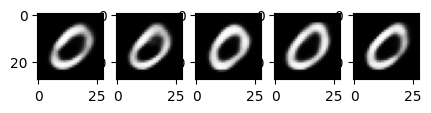

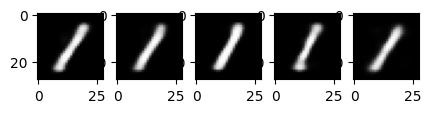

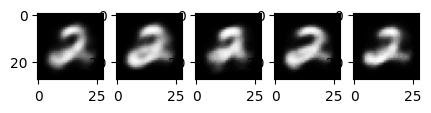

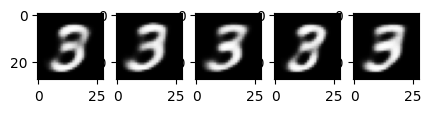

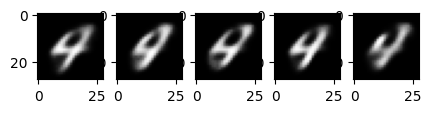

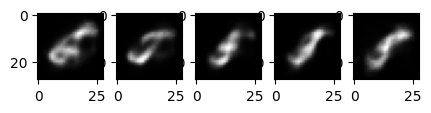

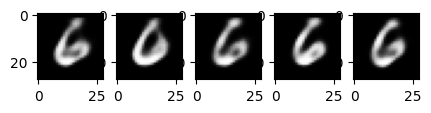

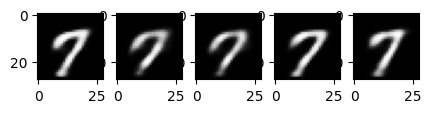

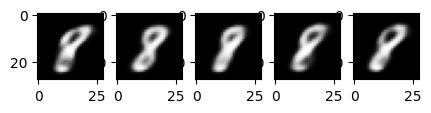

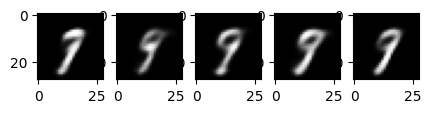

In [67]:
def inference(digit, num_examples=1):
    """
    Generates (num_examples) of a particular digit.
    Specifically we extract an example of each digit,
    then after we have the mu, sigma representation for
    each digit we can sample from that.

    After we sample we can run the decoder part of the VAE
    and generate examples.
    """
    images = []
    idx = 0
    for x, y in dataset:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break
    plt.figure(figsize=(9,2))
    plt.gray()
    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encoder(images[d].view(1, 784))
        encodings_digit.append((mu, sigma))

    mu, sigma = encodings_digit[digit]
    for example in range(num_examples):
        plt.subplot(2,9,example+1)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        out = model.decoder(z)
        a=out.view(28,28)
        out = out.view(-1, 1, 28, 28)
        plt.imshow(a.detach().numpy())
        # plt.imshow(a.detach().numpy())

        save_image(out, f"{path_to_dir}/generated_{digit}_ex{example}.png")

for idx in range(10):
    inference(idx, num_examples=5)